In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn
from matplotlib.colors import ListedColormap
import h5py
import skimage

# a. Auxiliary Functions

In [2]:
directions = [
    (-1, 0),  # North
    (1, 0),   # South
    (0, -1),  # West
    (0, 1),   # East
    (-1, -1), # Northwest
    (-1, 1),  # Northeast
    (1, -1),  # Southwest
    (1, 1),   # Southeast
]

def dfs(grid, visited, row, col):
    cols = grid.shape[1]
    rows = grid.shape[0]
    stack = [(row, col)]
    size = 0  # To track the size of the zone
    while stack:
        r, c = stack.pop()
        if not visited[r][c]:
            visited[r][c] = True
            size += 1  # Increment the size for each cell in the zone
            # Check all adjacent cells
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not visited[nr][nc] and grid[nr][nc]:
                    stack.append((nr, nc))
    return size

def count_zones_and_sizes(grid):
    cols = grid.shape[1]
    rows = grid.shape[0]
    visited = [[False for  _ in range(cols)] for _ in range(rows)]
    zone_sizes = []  # List to keep track of the sizes of each zone
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] and not visited[r][c]:
                # Start a new DFS to find the size of the connected component
                size = dfs(grid, visited, r, c)  # Get the size of the zone
                if size > 10:
                    zone_sizes.append(size)  # Store the size of the zone
                else:
                    pass
    return zone_sizes

# 1. Load the clustered data

In [3]:
data = np.load('D:/Data/Data_HSI/cluster.npy')

colors = ['xkcd:dark mauve', 'xkcd:white',  'xkcd:pale' , 'xkcd:light grey','xkcd:greenish grey']
cmp_init = ListedColormap(colors)

## 1.1 Visualize

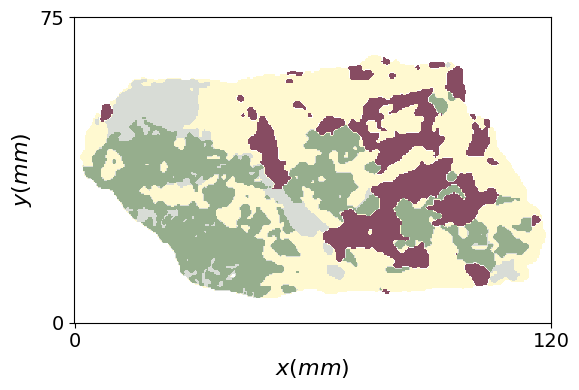

In [4]:
fig, ax = plt.subplots(figsize = (8, 4))

ax.imshow(skimage.filters.median(data), cmap = cmp_init)
ax.set_xlabel(r'$x (mm)$', fontsize = 16)
ax.set_ylabel(r'$y (mm)$', fontsize = 16)
ax.set_xticks([0, 320])
ax.set_xticklabels([0, 120], fontsize = 14)
ax.set_yticks([0, 205])
ax.set_yticklabels([75, 0], fontsize = 14)

fig.tight_layout()

In [5]:
pixel_size = (75/data.shape[0] + 120/data.shape[1])/2

In [6]:
pixel_size # mm

0.3704268292682927

# 2. Region Visualization

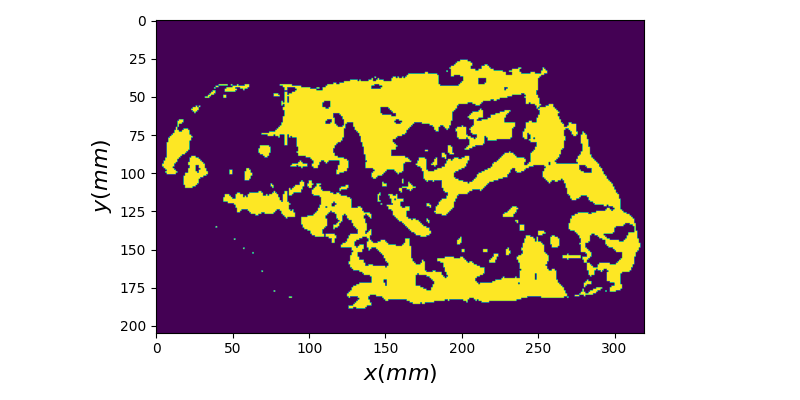

In [53]:
%matplotlib widget
fig, ax = plt.subplots(figsize = (8, 4))

mmap = (data == 2)
ax.imshow(mmap)
# ax.imshow(skimage.segmentation.mark_boundaries(data, data), alpha = 0.2)
ax.set_xlabel(r'$x (mm)$', fontsize = 16)
ax.set_ylabel(r'$y (mm)$', fontsize = 16)
# ax.set_xticks([0, 320])
# ax.set_xticklabels([0, 120], fontsize = 14)
# ax.set_yticks([0, 205])
# ax.set_yticklabels([75, 0], fontsize = 14)

fig.tight_layout()

# 3. Piece d' la resistance

In [8]:
filtered = skimage.filters.median(data)

In [77]:
label = ['Lepidolite', 'Background', 'Albite', 'Quartz', 'Mica']
pixel_area = pixel_size**2/100 # cm^2
total_areas = []

for miner in range(len(np.unique(data))):
    mineral_regions = (filtered == miner)
    zone_sizes = np.array(count_zones_and_sizes(mineral_regions))
    total_areas.append(zone_sizes*pixel_area)
    print(f'{label[miner]}: \n {len(zone_sizes)} grain regions. \n - Max grain size is {np.max(zone_sizes*pixel_area):.2f} cm² \n', 
          f'- Min is {np.min(zone_sizes*pixel_area):.2f} cm² \n - Mean grain size of {np.mean(zone_sizes*pixel_area):.2f} cm²')

total_areas = np.array(total_areas, dtype = object)

Lepidolite: 
 26 grain regions. 
 - Max grain size is 4.61 cm² 
 - Min is 0.00 cm² 
 - Mean grain size of 0.36 cm²
Background: 
 2 grain regions. 
 - Max grain size is 37.97 cm² 
 - Min is 0.01 cm² 
 - Mean grain size of 18.99 cm²
Albite: 
 43 grain regions. 
 - Max grain size is 13.47 cm² 
 - Min is 0.00 cm² 
 - Mean grain size of 0.53 cm²
Quartz: 
 66 grain regions. 
 - Max grain size is 2.67 cm² 
 - Min is 0.00 cm² 
 - Mean grain size of 0.08 cm²
Mica: 
 24 grain regions. 
 - Max grain size is 9.16 cm² 
 - Min is 0.00 cm² 
 - Mean grain size of 0.63 cm²


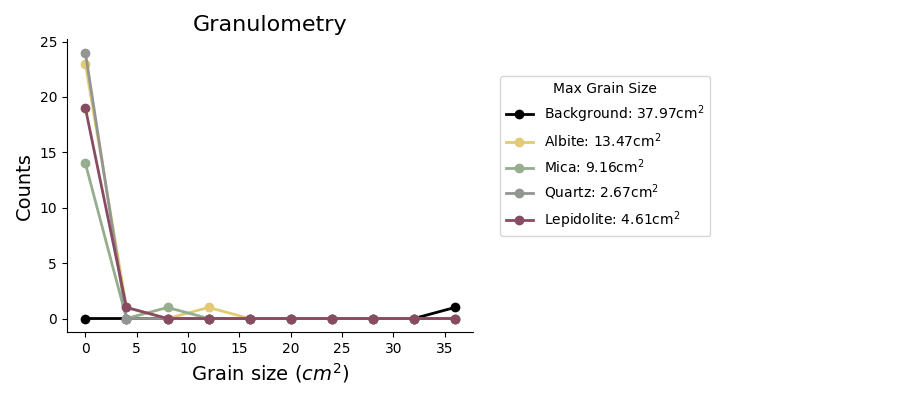

In [14]:
colors = ['xkcd:dark mauve', 'xkcd:black',  'xkcd:sand' , 'xkcd:grey','xkcd:greenish grey']
mineral = ['Lepidolite', 'Background', 'Albite', 'Quartz', 'Mica']
seq = [1, 2, 4, 3, 0]

fig, ax = plt.subplots(1, figsize = (9, 4))
for i in seq:
    hist, bin_edges = np.histogram(total_areas[i], bins = 10, range = (0, 40))
    ax.plot(bin_edges[:-1], hist, color = colors[i], label = f'{mineral[i]}: {np.max(total_areas[i]):.2f}' + r'cm$^2$', lw = 2, marker = 'o')
    # ax.hist(total_areas[i], bins = 5, range = (0, 40), color = colors[i], label = mineral[i])
    # current = hist*0
    # ax.fill_between(bin_edges[1:], current, current + hist, color = colors[i])
    # current += hist
ax.legend(bbox_to_anchor = (1.6, 0.6), loc = 'center right', title = "Max Grain Size")
ax.set_xlabel(r'Grain size ($cm^2$)', fontsize = 14)
ax.set_ylabel('Counts', fontsize = 14)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title('Granulometry', fontsize = 16)

fig.tight_layout()
# savefig('graph_grain_all.jpg', dpi = 300, bbox_inches = 'tight')

# e. Debug Flood Fill

In [64]:
directions = [
    (-1, 0),  # North
    (1, 0),   # South
    (0, -1),  # West
    (0, 1),   # East
    (-1, -1), # Northwest
    (-1, 1),  # Northeast
    (1, -1),  # Southwest
    (1, 1),   # Southeast
]

tracker = np.zeros((mmap.shape[0], mmap.shape[1]))

def dfs(grid, visited, row, col, counter):
    cols = grid.shape[1]
    rows = grid.shape[0]
    stack = [(row, col)]
    size = 0  # To track the size of the zone
    while stack:
        r, c = stack.pop()
        if not visited[r][c]:
            visited[r][c] = True
            tracker[r][c] = counter
            size += 1  # Increment the size for each cell in the zone
            # Check all adjacent cells
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols and not visited[nr][nc] and grid[nr][nc]:
                    stack.append((nr, nc))
    return size

def count_zones_and_sizes(grid):
    counter = 0
    cols = grid.shape[1]
    rows = grid.shape[0]
    visited = [[False for  _ in range(cols)] for _ in range(rows)]
    zone_sizes = []  # List to keep track of the sizes of each zone
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] and not visited[r][c]:
                counter = counter + 1
                # Start a new DFS to find the size of the connected component
                size = dfs(grid, visited, r, c, counter)  # Get the size of the zone
                zone_sizes.append(size)  # Store the size of the zone
    return zone_sizes

mmap = (data == 0)
zone_sizes = count_zones_and_sizes(mmap)
print("Zone Count:", len(zone_sizes))
print("Sizes of each contiguous zone:", zone_sizes)

Zone Count: 62
Sizes of each contiguous zone: [23, 2, 3, 2, 39, 1, 128, 10, 2, 217, 1, 25, 2, 19, 1, 1, 1, 1, 1, 16, 7, 1720, 1, 21, 38, 78, 46, 19, 8, 10, 622, 1, 264, 1, 2, 2, 3355, 29, 1, 4, 3, 1, 1, 38, 1, 7, 1, 1, 3, 183, 1, 1, 1, 19, 1, 1, 1, 1, 1, 1, 7, 1]


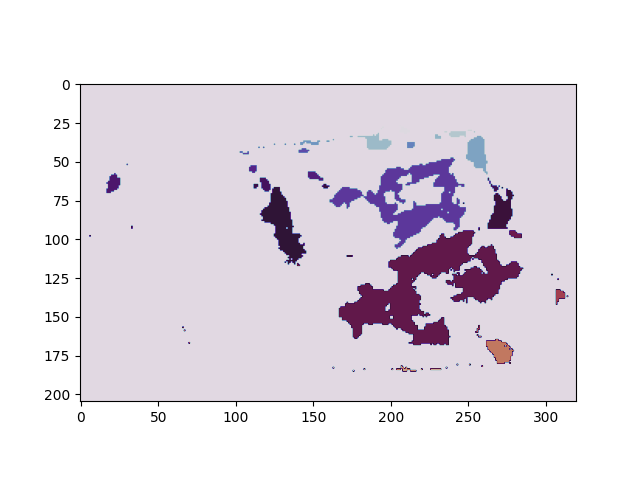

In [65]:
plt.subplots()
plt.imshow(tracker, cmap = 'twilight')